In [44]:
# This part adds the path c:\slipskip (or other directory where the repo is located) to the sys.path. 
# This is done so that blocks below can find the modules in other folders (eg. predictor.get_obs_from_api)
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [42]:
# This part executes all the data loading from APIs (get_obs_from_api.py) and does the preprocessing for data (weather_data_trimming.py).
# It takes in a list of cities and starts by searching all the observation stations in theses cities. 
# It then downloads the observations from these stations and basically takes an average over all the stations in one city.
# OBS! When excuting it prints quite a lot of "No observations found" because some of these stations are inactive. Don't worry about that.
import importlib
import numpy as np
import data.weather_data.weather_data_trimming as f
import predictor.get_obs_from_api as g
importlib.reload(f)
importlib.reload(g)

cities = ['Helsinki', 'Kuopio', 'Jyväskylä', 'Lahti', 'Oulu']

places = g.get_places()
df = g.get_daily_obs(cities, places)
dfh = g.get_hourly_obs(cities, places, df.columns)

df2 = f.rename_cols(df)
dfh2 = f.rename_cols(dfh)
df2 = f.merge_and_replace(df2, dfh2)


No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observa

In [45]:
# This part extracts features from the observation data. It returns a numpy array.
import model.weather_feature_extraction as m
import datetime as dt
importlib.reload(m)

df3 = m.get_features(df2, cities)
X_pred = df3.to_numpy()
date = df3.head(1).index.item() + dt.timedelta(days=1)

print(X_pred)

[['Helsinki' 15.5 0.0 3.12 10.02 0.0]
 ['Kuopio' 17.55 0.0 1.3 5.7 0.14]
 ['Jyväskylä' 27.2 0.0 -0.3 5.85 0.29]
 ['Lahti' 12.0 0.0 -1.1 7.9 0.14]
 ['Oulu' 8.2 0.0 0.23 5.97 0.14]]


In [41]:
# This part downloads the trained model and does the prediction for each city. 
# The output is a numpy array with Date, City, Binary prediction, Prediction as probability
import joblib

model = joblib.load('/slipskip/model/random_forest_model')
# model = joblib.load('./model/random_forest_model')

predictions = []
for i, city in enumerate(cities):
    single_pred = []
    single_pred.append(date.strftime("%m/%d/%Y"))
    single_pred.append(city)
    y_pred = model.predict(X_pred[i,1:].reshape(1,5))
    y_prob = model.predict_proba(X_pred[i,1:].reshape(1,5))
    single_pred.append(y_pred[0])
    single_pred.append(y_prob[0][1])
    predictions.append(single_pred)

predictions = np.array(predictions)

print(predictions)

[['10/23/2022' 'Helsinki' '0.0' '0.0']
 ['10/23/2022' 'Kuopio' '0.0' '0.0']
 ['10/23/2022' 'Jyväskylä' '0.0' '0.01']
 ['10/23/2022' 'Lahti' '0.0' '0.0']
 ['10/23/2022' 'Oulu' '0.0' '0.0']]


In [23]:
import geopandas as gpd

# Reading shapefile of map of Finland and creating df for coordinates of cities.
shapefile = 'slipskip/finland_shapefile/fi_1km.shp'
# shapefile = './finland_shapefile/fi_1km.shp'

finMap = gpd.read_file(shapefile)
data = {'City': ['Helsinki', 'Lappeenranta', 'Jyväskylä', 'Oulu', 'Kuopio'],
           'Latitude': [60.17332, 61.05499, 62.242603, 65.012093, 62.897968],
           'Longitude': [24.94102, 28.18966, 25.747257, 25.465076, 27.678171]}

longLat = pd.DataFrame(data)

In [21]:
from shapely.geometry import Point, Polygon

# Creating map of Finland
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(longLat['Longitude'], longLat['Latitude'])]
geo_df = gpd.GeoDataFrame(longLat, 
                          crs = crs, 
                          geometry = geometry)

# Putting slip warning to the cities not covered yet
geo_df['value'] = 1

# Putting predicted value to Helsinki.
geo_df.loc[0,'value'] = y_pred
print(geo_df)

           City   Latitude  Longitude                   geometry  value  \
0      Helsinki  60.173320  24.941020  POINT (24.94102 60.17332)      0   
1  Lappeenranta  61.054990  28.189660  POINT (28.18966 61.05499)      1   
2     Jyväskylä  62.242603  25.747257  POINT (25.74726 62.24260)      1   
3          Oulu  65.012093  25.465076  POINT (25.46508 65.01209)      1   
4        Kuopio  62.897968  27.678171  POINT (27.67817 62.89797)      1   

    color  
0   green  
1  orange  
2  orange  
3  orange  
4  orange  


c:\Users\eliel\anaconda3\envs\my_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [22]:
# Creating color column
geo_df['color'] = geo_df['value'].mask(geo_df['value'] == 1, 'orange')
geo_df['color'] = geo_df['color'].mask(geo_df['color'] == 0, 'green')
print(geo_df['color'])

0     green
1    orange
2    orange
3    orange
4    orange
Name: color, dtype: object


Text(0.5, 1.0, 'Slip warnings in Finland')

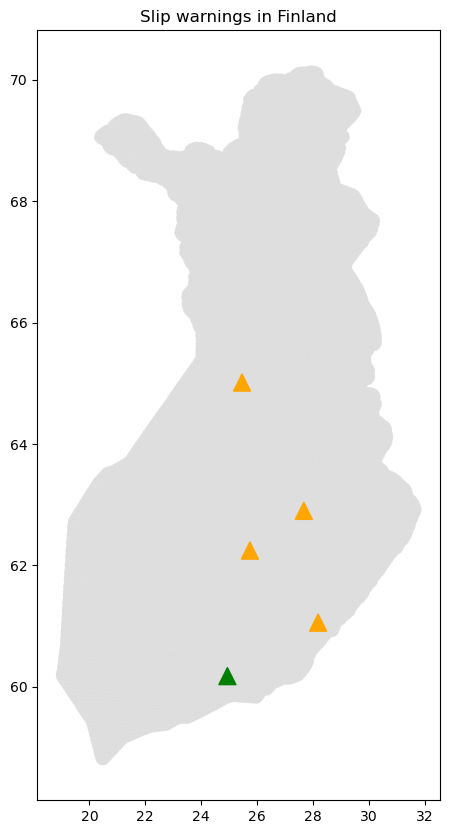

In [20]:
import matplotlib.pyplot as plt

# Create map, green if no warning, orange if warning
fig, ax = plt.subplots(figsize = (10,10))
finMap.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax,c=geo_df['color'], marker='^', markersize=150)
ax.set_title('Slip warnings in Finland')